### **Requirements**
***In Colab, you don't need to install anything extra for our project.***

For the data, we use Roboflow to help convert the annotation format from YOLO to coco format, when applying the training data, please check the directory structure carefully. 



- In this notebook, we access data from folder "Airborne rescue_integral", which are the AHE post-preprocessing integrals downloaded from the link provided in the course, please change this folder name to your target folder.
- All the data we used are in the folder "Data for experiments".
- The data augmentation were also done with Roboflow platform.

**One of experiments**
 - Using erode preprocessed data:
 https://colab.research.google.com/drive/13Kdno_o_fxV60hpmfpBSgwBR52Tul7J8?usp=sharing

**Other models used in this lab project**

1. YOLOv5:
https://colab.research.google.com/drive/1MY4vmYQpbBzjch9Nc3OI-jtFXZDmJU2z?usp=sharing

2. RetinaNet:
https://colab.research.google.com/drive/1Gx4EdXCCA1ufHnnm5EfnvB4kp3TBPb0v?usp=sharing

In [ ]:
%matplotlib inline
import pycocotools.coco as coco
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
from PIL import Image
import pandas as pd

pylab.rcParams['figure.figsize'] = (10.0, 8.0)

### Basic settings for GPU

In [ ]:
# Ensure colab doesn't disconnect
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [ ]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

torch.set_grad_enabled(False);

1.7.0+cu101 True


## Clone custom code of DETR

Clone from [woctezuma](https://github.com/woctezuma/detr/tree/finetune) tailored for a custom dataset:
-   called `custom`,
-   with `max_class_id = 2` ([explanation](https://github.com/facebookresearch/detr/issues/108#issuecomment-650269223)).

**Caveat**: if you later use `first_class_index = 1` for your dataset, then it is fine. However, if you later use `first_class_index = 0`, then you will have to override the value of `max_class_id` (so that it is equal to 1) when calling `!python main.py`. My fork can do that.


In [ ]:
%cd /content/

!rm -rf detr
!git clone https://github.com/woctezuma/detr.git

%cd detr/

!git checkout finetune

/content
Cloning into 'detr'...
remote: Enumerating objects: 239, done.
remote: Total 239 (delta 0), reused 0 (delta 0), pack-reused 239
Receiving objects: 100% (239/239), 292.33 KiB | 11.24 MiB/s, done.
Resolving deltas: 100% (128/128), done.
/content/detr
Branch 'finetune' set up to track remote branch 'finetune' from 'origin'.
Switched to a new branch 'finetune'


## Load pre-trained weights

Load a check-point (urls can be found [here](https://github.com/facebookresearch/detr#model-zoo)), then remove the classification head.

In [ ]:
# Get pretrained weights
checkpoint = torch.hub.load_state_dict_from_url(
            url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
            map_location='cpu',
            check_hash=True)

# Remove class weights
del checkpoint["model"]["class_embed.weight"]
del checkpoint["model"]["class_embed.bias"]

# Save
torch.save(checkpoint,
           'detr-r50_no-class-head.pth')

Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth


## Prepare the dataset for fine-tuning

Here are two ways to **access your custom data**:
1. Connect to google drive and load the traing data from the directory.
2. Upload the files to colab everytime. 

Here we use the first one. For checking the files you can access here, click the folder icon at the left-hand side.

**Note**: When Colab is disconnected, you will lose all files and excution data.

### Access the data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
### This cell is the second option for loading the data(not suggested)

# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

**The expected directory structure according to the finetuning script should be the following:**
```
path/
├ annotations/  # JSON annotations
│  ├ annotations/custom_train.json
│  └ annotations/custom_val.json
│  └ annotations/custom_test.json
├ train2017/    # training images
└ val2017/      # validation images
└ test/         # testing images
```

In [ ]:
# Set the starting class index
first_class_index = 0

**Read the registered coco format annotations**

Be careful with the working directory by setting "dataDir" (needs to end with '/' for later use)

In [ ]:
# Set the working directory
dataDir= '/content/gdrive/My Drive/CV_Project/CV Lab Project - D5/Airborne rescue_integral/'
dataType='train2017'
annFile='{}annotations/custom_train.json'.format(dataDir)


# initialize COCO api for instance annotations
coco=COCO(annFile)

# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
print(cats)
nms=[cat['name'] for cat in cats]
print('Categories: {}'.format(nms),'\n')

nms = set([cat['supercategory'] for cat in cats])
print('Super-categories: {}'.format(nms),'\n')

# load and display image
catIds = coco.getCatIds(catNms=['person']);
imgIds = coco.getImgIds(catIds=catIds );

loading annotations into memory...
Done (t=0.29s)
creating index...
index created!
[{'id': 0, 'name': 'persons', 'supercategory': 'none'}, {'id': 1, 'name': '0', 'supercategory': 'persons'}]
Categories: ['persons', '0'] 

Super-categories: {'persons', 'none'} 



In [ ]:
img = coco.loadImgs(0)[0]
img_name = '%s/%s/%s'%(dataDir, dataType, img['file_name'])
print('Image name: {}'.format(img_name))
im = Image.open(img_name)

original_size = im.size
print(original_size)

Image name: /content/gdrive/My Drive/CV_Project/CV Lab Project - D5/Airborne rescue_integral//train2017/KW20200117emptyF1_rot120_fpH0-00_rx-2-0_ry0-0_png.rf.2fbb9b8532f77ff919f56d3c20fd523d.jpg
(416, 416)


### Define boilerplate functions

Adapted from:
-   https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_attention.ipynb

In [ ]:
import torchvision.transforms as T

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5*w), (y_c - 0.5*h),
         (x_c + 0.5*w), (y_c + 0.5*h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [ ]:
def filter_bboxes_from_outputs(outputs, threshold=0.7):
  
  # keep only predictions with confidence above threshold
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  
  keep = probas.max(-1).values > threshold

  probas_to_keep = probas[keep]

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], original_size)
  
  return probas_to_keep, bboxes_scaled

In [ ]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [ ]:
def plot_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()
          text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

## Fine-tuning

-   Instructions appear in [a Github Gist](https://gist.github.com/woctezuma/e9f8f9fe1737987351582e9441c46b5d).

**Note**: There is a `--frozen_weights` argument. However, "frozen training is meant for segmentation only" (as mentioned at this [line](https://github.com/facebookresearch/detr/blob/f4cdc542de34de771da8b9189742e5465f5220cd/main.py#L110) of the source-code).

### Boilerplate variables
**This variable should be adjusted depending on the first_class_index**

**Caveat**: the parameter name `num_classes` is misleading. It is actually the ID which DETR will reserve for **its own** `no_object` class.

It should be set to one plus the highest class ID in your dataset.

For instance, if you have one class (balloon):
- if you used the index n°0 for this class, then `max_id = 0` and `num_classes = max_id+1 = 1`
- if you used the index n°1 for this class, then `max_id = 1` and `num_classes = max_id+1 = 2`

Reference: https://github.com/facebookresearch/detr/issues/108#issuecomment-650269223

In [ ]:
assert(first_class_index in [0, 1])

if first_class_index == 0:


  num_classes = 2

  finetuned_classes = ['persons','0'] 
 

else:


  num_classes = 3

  finetuned_classes = [
      'N/A', 'persons','0'
  ]


print('First class index: {}'.format(first_class_index))  
print('Parameter num_classes: {}'.format(num_classes))
print('Fine-tuned classes: {}'.format(finetuned_classes))

First class index: 0
Parameter num_classes: 2
Fine-tuned classes: ['persons', '0']


In [ ]:
%cd /content/detr/

/content/detr


**Caveat**: below, we override the value of `num_classes` (hard-coded to 2 for the `custom` dataset in `finetune` branch of DETR) in case `first_class_index = 0` instead of `first_class_index = 1` (default value).

## Start Training!

**Note**: For the final presentation 20 epochs were used.

In [ ]:

!python main.py \
  --dataset_file "custom" \
  --coco_path "/content/gdrive/My Drive/CV_Project/CV Lab Project - D5/Airborne rescue_integral/" \
  --output_dir "outputs" \
  --resume "detr-r50_no-class-head.pth" \
  --num_classes $num_classes \
  --epochs 5

Not using distributed mode
git:
  sha: e42a3b174d2325c28f82d7114138c755ac7c095a, status: clean, branch: finetune

Namespace(aux_loss=True, backbone='resnet50', batch_size=2, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path='/content/gdrive/My Drive/CV_Project/CV Lab Project - D5/Airborne rescue_integral/', dataset_file='custom', dec_layers=6, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=5, eval=False, frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=0.0001, lr_backbone=1e-05, lr_drop=200, mask_loss_coef=1, masks=False, nheads=8, num_classes=2, num_queries=100, num_workers=2, output_dir='outputs', position_embedding='sine', pre_norm=False, remove_difficult=False, resume='detr-r50_no-class-head.pth', seed=42, set_cost_bbox=5, set_cost_class=1, set_cost_giou=2, start_epoch=0, weight_decay=0.0001, world_size=1)
number of params: 41279495
loading an

**(Optional) Copy the important training files to your drive**

You can simply load these files to use the trained model and evaluate the model performance in the future.

In [ ]:
!cp outputs/checkpoint.pth /content/gdrive/MyDrive
!cp outputs/log.txt /content/gdrive/MyDrive

## **Fine-tuned Results**

### Monitoring of training

Reference: https://github.com/lessw2020/Thunder-Detr/blob/master/View_your_training_results.ipynb

In [ ]:
from util.plot_utils import plot_logs
from pathlib import Path

# load the training log
log_directory = [Path('outputs/')]

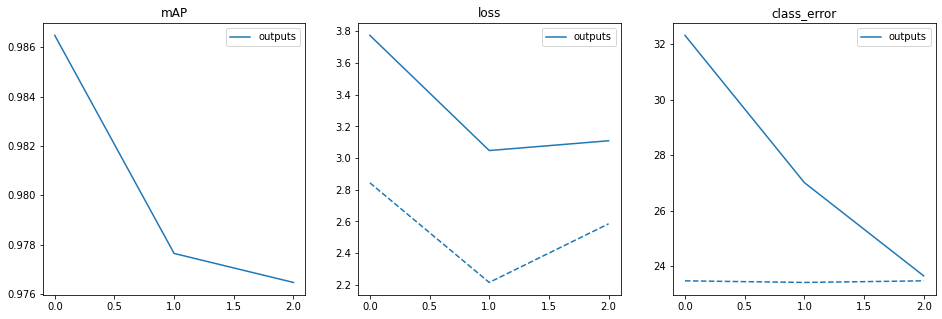

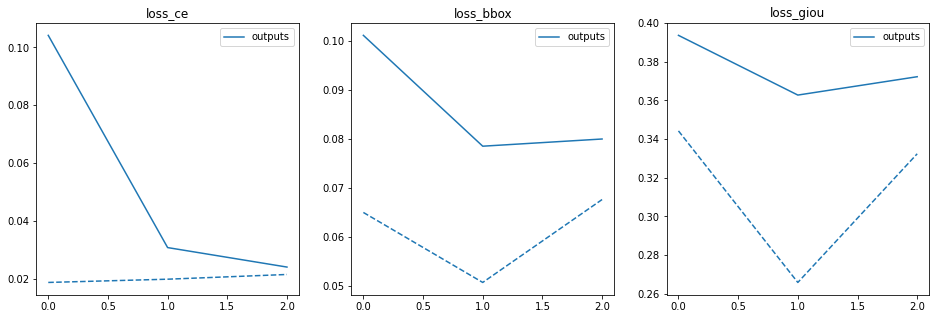

In [ ]:
# plot the evaluation during training
fields_of_interest1 = (
    'mAP',
    'loss',
    'class_error'
    )

fields_of_interest2 = (
    'loss_ce',
    'loss_bbox',
    'loss_giou',
    )


plot_logs(log_directory,fields_of_interest1)
plot_logs(log_directory,fields_of_interest2)

### Load the fine-tuned model

- How to replace the classification head: https://github.com/facebookresearch/detr/issues/9#issuecomment-636391562

In [ ]:
# Load the model configuration
model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=num_classes)

# Load the training checkpoint data (If you want to use the checkpoint before, adjust the path)
checkpoint = torch.load('outputs/checkpoint.pth',
                        map_location='cpu')

# Assign the finetuned model for prediction
model.load_state_dict(checkpoint['model'],
                      strict=False)
# the evaluation mode
model.eval();

Downloading: "https://github.com/facebookresearch/detr/archive/master.zip" to /root/.cache/torch/hub/master.zip


### Boilerplate functions for displaying fine-tuned results

In [ ]:
def plot_finetuned_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()
          text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    # plt.axis('off')
    plt.show()


####
def run_worflow(my_image, my_model):
  # mean-std normalize the input image (batch-size: 1)
  img = transform(my_image).unsqueeze(0)
  
  print("transformed size:", img.shape)

  # propagate through the model
  outputs = my_model(img)
  # probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  # print(outputs)

  for threshold in [0.9, 0.7]:
    
    probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs, threshold=threshold)
    plot_finetuned_results(my_image,
                           probas_to_keep, 
                           bboxes_scaled)    

In [ ]:
# compare with ground truth
### Randomly choose an image

def Compare(dataType,annFile):
  # initialize COCO api for instance annotations
  coco=COCO(annFile)

  # display COCO categories and supercategories
  cats = coco.loadCats(coco.getCatIds())
  nms=[cat['name'] for cat in cats]
  nms = set([cat['supercategory'] for cat in cats])


  # load and display image
  catIds = coco.getCatIds(catNms=['person']);
  imgIds = coco.getImgIds(catIds=catIds );

  img_id = imgIds[np.random.randint(0,len(imgIds))]

  img = coco.loadImgs(img_id)[0]

  # dataType='train'
  img_name = '%s/%s/%s'%(dataDir, dataType, img['file_name'])


  ### Plot the prediction
  print("---IMG---:", img_id)
  im = Image.open(img_name)
  run_worflow(im,model)
  

  ### Plot the ground truth
  I = io.imread(img_name)

  annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
  anns = coco.loadAnns(annIds)
  # print("Ann:",anns)
  plt.imshow(I)
  coco.showAnns(anns, draw_bbox=True)
  

## **Work on Testing Data**

In [ ]:
# Get all the testing data
dataDir= '/content/gdrive/My Drive/CV_Project/CV Lab Project - D5/Airborne rescue_integral/'
DataType = 'test'
AnnFile='{}annotations/custom_test.json'.format(dataDir)


# initialize COCO api for instance annotations
coco=COCO(AnnFile)

# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
nms = set([cat['supercategory'] for cat in cats])


# load and display image
catIds = coco.getCatIds(catNms=['person']);
imgIds = coco.getImgIds(catIds=catIds );

test_output = []
Probs = []
Keep = []
BB_scale = []
Anns = []


for img_id in imgIds:
  img = coco.loadImgs(img_id)[0]
  img_name = '%s/%s/%s'%(dataDir, DataType, img['file_name'])
  # predict testing data
  im = Image.open(img_name)
  img = transform(im).unsqueeze(0)
  output = model(img)
  test_output.append(output)

  # Load the ground truth
  I = io.imread(img_name)
  img_id = img_id
  img = coco.loadImgs(img_id)[0]
  annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)

  anns = coco.loadAnns(annIds)
  Anns.append(anns)

  for threshold in [0.9, 0.7]: 
    probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(output, threshold=threshold)
  Keep.append(probas_to_keep)
  BB_scale.append(bboxes_scaled)

  # keep only predictions with 0.7+ confidence
  probas = output['pred_logits'].softmax(-1)[0, :, :-1]
  Probs.append(probas)
  Compare(DataType, AnnFile)


Output hidden; open in https://colab.research.google.com to view.

## Define the Evaluation Functions

### **IoU**

In [ ]:
def calc_iou( gt_bbox, pred_bbox):
    '''
    This function takes the predicted bounding box and ground truth bounding box and 
    return the IoU ratio
    '''
    x_topleft_gt, y_topleft_gt, x_bottomright_gt, y_bottomright_gt = gt_bbox
    x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p = pred_bbox

    
    if (x_topleft_gt > x_bottomright_gt) or (y_topleft_gt > y_bottomright_gt):
        raise AssertionError("Ground Truth Bounding Box is not correct",x_topleft_gt, x_bottomright_gt,y_topleft_gt,y_bottomright_gt)
    if (x_topleft_p > x_bottomright_p) or (y_topleft_p > y_bottomright_p):
        raise AssertionError("Predicted Bounding Box is not correct",x_topleft_p, x_bottomright_p,y_topleft_p,y_bottomright_p)
        
         
    #if the GT bbox and predcited BBox do not overlap then iou=-1
    if (x_bottomright_gt < x_topleft_p) or (y_bottomright_gt < y_topleft_p) or (x_topleft_gt > x_bottomright_p) or (y_topleft_gt > y_bottomright_p):   
        return -1
    else:    
    
      GT_bbox_area = (x_bottomright_gt -  x_topleft_gt ) * (  y_bottomright_gt -y_topleft_gt )
      Pred_bbox_area =(x_bottomright_p - x_topleft_p ) * ( y_bottomright_p -y_topleft_p )
      
      x_top_left =np.max([x_topleft_gt, x_topleft_p])
      y_top_left = np.max([y_topleft_gt, y_topleft_p])
      x_bottom_right = np.min([x_bottomright_gt, x_bottomright_p])
      y_bottom_right = np.min([y_bottomright_gt, y_bottomright_p])
      
      intersection_area = (x_bottom_right- x_top_left ) * (y_bottom_right-y_top_left )
      union_area = (GT_bbox_area + Pred_bbox_area - intersection_area)
    
      return intersection_area/union_area

### **Precision and Recall**

In [ ]:
def prec_recall(tp, fp, total, non_detected):
  p = tp / (tp+fp)
  r = tp / (tp + non_detected)
  
  return p, r

### **Sort pedictions by confidence**

In [ ]:
def Sort(sub_li): 
    l = len(sub_li) 
    for i in range(0, l): 
        for j in range(0, l-i-1): 
            if (sub_li[j][0] < sub_li[j + 1][0]): 
                tempo = sub_li[j] 
                sub_li[j]= sub_li[j + 1] 
                sub_li[j + 1]= tempo 
    return sub_li 

### **Evaluation function - TP, FP, FN, mAP**

In [ ]:
def test_evaluation(iou_threshold, title):
  tp = 0
  fp = 0
  total = 0
  predictions = 0
  C = []
  non_detected = 0
  for i in range(0,len(test_output)):
    total += len(Anns[i])
    predictions += len(BB_scale[i])

    if len(Anns[i])==0:
      fp += len(BB_scale[i])
    else:
    
      gts = []
      detections = []
      b = set()
      for n in range(0,len(Anns[i])):
        x, y, w, h= Anns[i][n]['bbox']
        gt_bbox = [x, y, x + w, y + h]
        gts.append(gt_bbox)
        b.add(tuple(gt_bbox))

      preds = BB_scale[i].tolist()
      for pred,c in zip(preds, Keep[i]):
        l,r = c
        confidence = float(r) - float(l)

        
        temp = 0
        for gt in gts:
          iou = calc_iou(gt, pred)
          if iou != 0:
            detections.append(gt)
          if iou > temp: 
            temp = iou
        
        if temp >= iou_threshold:
          tp += 1
          C.append([confidence, 1, 0])
          # print("Tp img:",i,pred,confidence)
          
        else:
          fp += 1
          C.append([confidence, 0, 1])
          # print("fp img:",i, pred, confidence)

      a = set()
      for d in detections:
        a.add(tuple(d))
      
      non_detected += len(b.difference(a))

  print("TP:", tp)
  print("FP:", fp)
  print("Missed Person:", non_detected)
  print('==========================')
  print("total ground truth -",total)
  print("total predictions -",predictions)
  P, R = prec_recall(tp, fp, total,non_detected)
  print("==========================")
  print("Precision:", P, "Recall:", R)


  ### Data preparation for calculating mAP

  curve_data = Sort(C)
  # Define the dataframe columns as [Confidence, TP, FP, AccTP, AccFP, Precision, Recall]
  df = pd.DataFrame(curve_data, columns=['Confidence', 'TP', 'FP'])
  df['AccTP'] = 0
  df['AccFP'] = 0
  df['Precision'] = 0
  df['Recall'] = 0


  # Calculate AccTP & AccFP
  df.iloc[0,3] = df.iloc[0,1]
  df.iloc[0,4] = df.iloc[0,2]

  for i in range(0,len(df)-1):
    df.iloc[i+1,3] = df.iloc[i+1,1] + df.iloc[i,3]
    df.iloc[i+1,4] = df.iloc[i+1,2] + df.iloc[i,4]

  for i in range(0,len(df)):
    tp = df.iloc[i,3]
    fp = df.iloc[i,4]
    p, r= prec_recall(tp, fp, total, non_detected) 

    df.iloc[i,5] = p
    df.iloc[i,6] = r


  # plot the Precision-Recall Curve
  plt.plot(df['Recall'],df['Precision'])
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title(title)
  plt.show()

  # Define the interpolation points for calculating mAP
  points = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

  # get the precision at the point!
  AP = 1
  for p in range(1, len(points)):
    position = df[df['Recall'] >= points[p]].index
    if len(position) != 0:
      avg = (df.iloc[position[0]-1,-2] + df.iloc[position[0],-2]) / 2
    else:
      avg = 0

    print('precision:', avg,'point:', l)
    AP += avg  
    
  print("sum of precision:",AP)    

  mAP = AP/11
  print("==========")
  print("mAP:", mAP)

### **mAP@75**

TP: 321
FP: 164
Missed Person: 0
total ground truth - 432
total predictions - 485
Precision: 0.6618556701030928 Recall: 1.0


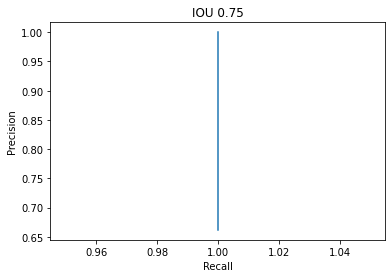

precision: 0.8309278350515463 point: tensor(0.0075)
precision: 0.8309278350515463 point: tensor(0.0075)
precision: 0.8309278350515463 point: tensor(0.0075)
precision: 0.8309278350515463 point: tensor(0.0075)
precision: 0.8309278350515463 point: tensor(0.0075)
precision: 0.8309278350515463 point: tensor(0.0075)
precision: 0.8309278350515463 point: tensor(0.0075)
precision: 0.8309278350515463 point: tensor(0.0075)
precision: 0.8309278350515463 point: tensor(0.0075)
precision: 0.8309278350515463 point: tensor(0.0075)
sum of precision: 9.309278350515463
mAP: 0.846298031865042


In [ ]:
test_evaluation(0.75, title='IOU 0.75')

### **mAP@50**

TP: 466
FP: 19
Missed Person: 0
total ground truth - 432
total predictions - 485
Precision: 0.9608247422680413 Recall: 1.0


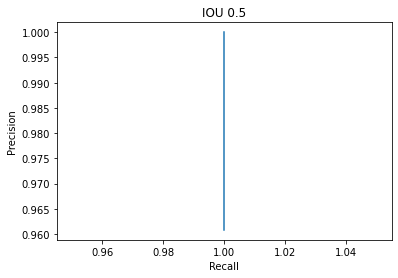

precision: 0.9804123711340207 point: tensor(0.0075)
precision: 0.9804123711340207 point: tensor(0.0075)
precision: 0.9804123711340207 point: tensor(0.0075)
precision: 0.9804123711340207 point: tensor(0.0075)
precision: 0.9804123711340207 point: tensor(0.0075)
precision: 0.9804123711340207 point: tensor(0.0075)
precision: 0.9804123711340207 point: tensor(0.0075)
precision: 0.9804123711340207 point: tensor(0.0075)
precision: 0.9804123711340207 point: tensor(0.0075)
precision: 0.9804123711340207 point: tensor(0.0075)
sum of precision: 10.804123711340207
mAP: 0.9821930646672915


In [ ]:
test_evaluation(0.5, title='IOU 0.5')

### **mAP@10**

TP: 471
FP: 14
Missed Person: 0
total ground truth - 432
total predictions - 485
Precision: 0.9711340206185567 Recall: 1.0


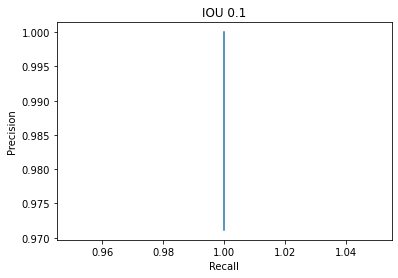

precision: 0.9855670103092784 point: tensor(0.0075)
precision: 0.9855670103092784 point: tensor(0.0075)
precision: 0.9855670103092784 point: tensor(0.0075)
precision: 0.9855670103092784 point: tensor(0.0075)
precision: 0.9855670103092784 point: tensor(0.0075)
precision: 0.9855670103092784 point: tensor(0.0075)
precision: 0.9855670103092784 point: tensor(0.0075)
precision: 0.9855670103092784 point: tensor(0.0075)
precision: 0.9855670103092784 point: tensor(0.0075)
precision: 0.9855670103092784 point: tensor(0.0075)
sum of precision: 10.855670103092784
mAP: 0.9868791002811622


In [ ]:
test_evaluation(0.1, title='IOU 0.1')